<h3 style="background-color:blue;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Introduction</h3>


# 👋 Hello Kagglers!
>There have been many advanced technology in the field of medical sciences.One of the initial breakthrough in medicine is in the diagnosis process. Especially Lungs,Heart.In early days doctor used to manually view the Xray copies and detect whether the patient has any problem or not.Due to the arrival of machine learning the process requires no human intervention and AI has been acing since then
>
>In this notebook we are building a similar algorithm for such application where we classify the lung Xrays on whether it has symptom of Pneumonia or not
>
>I am also planning to explore more on image dataset in upcoming notebooks using trained models.

## ❓ What is Pneumonia
>Pneumonia is a lung infection that can range from mild to so severe that you have to go to the hospital. It happens when an infection causes the air sacs in your lungs (your doctor will call them alveoli) to fill with fluid or pus. That can make it hard for you to breathe in enough oxygen to reach your bloodstream.

## 📜 Causes of Pneumonia

>Bacteria, viruses, or fungi can cause pneumonia.
>
> ### Common causes include:
>* Flu viruses
>* Cold viruses
>* RSV virus (the top cause of pneumonia in babies age 1 or younger)
>* Bacteria called Streptococcus pneumoniae and Mycoplasma pneumoniae
>* Lifestyle habits, like smoking cigarettes and drinking too much alcohol, can also raise your chances of getting pneumonia.
> [Credits](https://www.webmd.com/lung/understanding-pneumonia-basics)

<h3 style="background-color:blue;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Libraries And Utilities</h3>


In [1]:
#Basic libraries
import os
import glob
import numpy as np
import pandas as pd

#Visualization libraries
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#ML libraries
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

#DL libraries
import tensorflow as tf
from keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

#Setting a seed
np.random.seed(22)

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 🧮 Getting the data

>We have all the images stored in folders of test, train and val. Now we are going to extract those images as path add a '.jpeg' extension and merge the normal and pneumonia affected lung X-Rays by giving them labels. We then store these information in a dataframe

In [2]:
#Function for reading the images
def get_data(path,label):
    '''The function returns array of images and their respective label
        It also resizes the image and gives the color
        
        Parameters:
        1.path-path of the image directory
        2.label-label for the images '''
    
    #Reading the file name of images
    files=np.array(os.listdir(path))
    
    #Adding the user defined labels
    labels=np.array([label]*len(files))
    
    #Read the images using cv2 and resizing the images
    images=[]
    for image in files:
        image=cv2.imread(path+image)
        image=cv2.resize(image,dsize=(200,200))
        image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        images.append(image)
        
    #Converting to array
    images=np.array(images)
    
    return images,labels

#Applying the function and get the images for the normal and pneumonia images for training
normal_images,normal_labels=get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/','normal')
pneumonia_images,pneumonia_labels=get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/','pneumonia')

#Applying the function and get the images for the normal and pneumonia images for testing
normal_images_test,normal_labels_test=get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/','normal')
pneumonia_images_test,pneumonia_labels_test=get_data('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/','pneumonia')


#Preparing the independent and dependent training set
X_train=np.append(normal_images,pneumonia_images,axis=0)
y_train=np.append(normal_labels,pneumonia_labels)

#Preparing the independent and dependent testing set
X_test=np.append(normal_images_test,pneumonia_images_test,axis=0)
y_test=np.append(normal_labels_test,pneumonia_labels_test)

#Displaying the shape of data
print("Image size: ",X_train.shape)
print("Label size: ",y_train.shape)

#Displaying the number of labels
print("Labels: ",np.unique(y_train))

Image size:  (5216, 200, 200)
Label size:  (5216,)
Labels:  ['normal' 'pneumonia']


In [3]:
#Storing the path
path = "/kaggle/input/chest-xray-pneumonia/chest_xray/"

#Setting the labels
sets = ["train", "test", "val"]

#Creating empty lists to store images
all_pneumonia = []
all_normal = []

#Appending the normal and pneumonia images
for i in sets:
    path = os.path.join(path, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(normal)
    all_pneumonia.extend(pneumonia)

<h3 style="background-color:blue;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Exploratory data analysis</h3>


>Let's view the X rays of affected and healthy lung and try to extract any visual information
>First lets view the actual grayscale images, here we have only 2 dimension as the 3rd dimension is absent(colour)

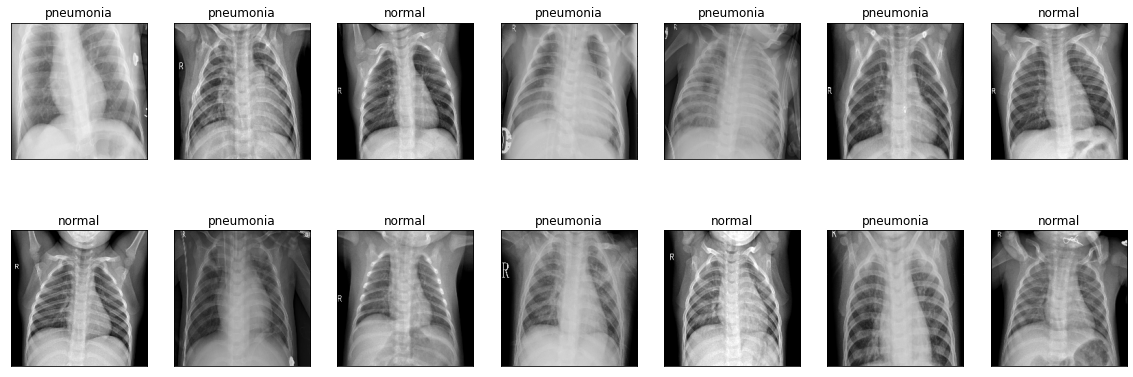

In [4]:
#Setting up the plot size
fig,ax=plt.subplots(ncols=7,nrows=2,figsize=(20,7))

#Getting random index points
indices=np.random.choice(len(X_train),14)
counter=0

#Displaying subplots of images with labels
for i in range(2):
    for j in range(7):
        ax[i,j].set_title(y_train[indices[counter]])
        ax[i,j].imshow(X_train[indices[counter]],cmap='gray')
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        counter+=1

plt.show()

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
From the pictures we can identify that the pneumonia images have more pale white occupying most of the lung area and the picture of normal lung xray is more dark and visible 
</div

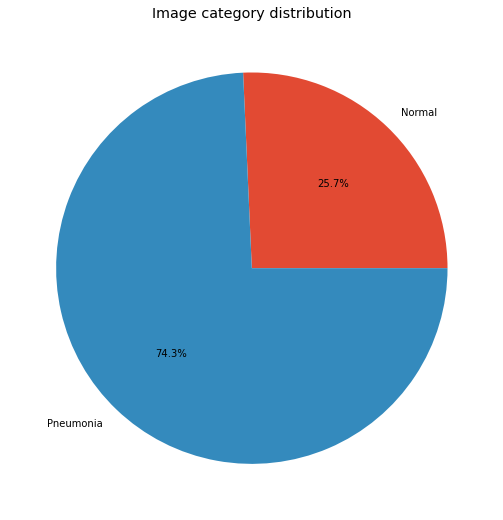

In [5]:
#labelling the output
labels=['Normal','Pneumonia']

#Getting the sum of each outcome
targets=[len(normal_images),len(pneumonia_images)]

#Plotting the piechart
plt.style.use('ggplot')
plt.figure(figsize=(16,9))
plt.pie(x=targets,labels=labels,autopct="%1.1f%%")
plt.title("Image category distribution")
plt.show()

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
We can declare that we have an unbalanced data where we got a upperhand in pneumonia images and normal pictures are very low. Even though on generalizing that we have less number of normal lungs than pneumonia affected lungs, it is crucial to reduce false positives now<br>
<br>  
<b>💡Solution:</b> <br>
 The best solution we have at hand is Data Augmentation, where we can re-sample existing images and create new images by changing the properties of the images 
</div

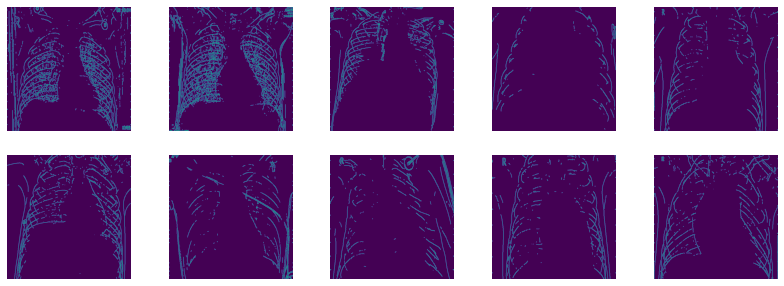

In [6]:
#Setting the figsize
fig=plt.figure(figsize=(14, 5))

#Setting up the frame for subplots
columns = 5; rows = 2

#Partitioning the dataset
images=all_pneumonia[:50]+all_normal[:50]

#Plotting the images
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

<div class="alert alert-block alert-info">
<b>🔍Inference:</b> <br>
Edge detection in our application is crucial as we already inferred that the rib bones and lung is pale white and the edges where barely visible. But incase of normal Xrays the bones were clearly visible which is captured clearly in the above visuals
</div

<h3 style="background-color:blue;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Preparing the data</h3>


## 🔧 Encoding and Reshaping

>We cant feed the images directly to the neural network, instead we reshape the grayscale images by adding one more dimension. Also we can encode the labels using onehotencoder

In [7]:
#Reshaping the dataset by adding a new axis
y_train=y_train[:,np.newaxis]
y_test=y_test[:,np.newaxis]

#Initialize onehot encoder
encode=OneHotEncoder(sparse=False)

#Encoding the images
y_train_encode=encode.fit_transform(y_train)
y_test_encode=encode.transform(y_test)

In [8]:
#Reshaping the independent data
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

## 📷 Data Augmentation

>Since we got a imbalanced data, lets augment the data and create more images by rotating, zooming and change the width and height. Doing that will help in reducing the bias of model and also generalize it

In [9]:
#Data augumentation using ImageDataGenerator
datagen=ImageDataGenerator(
rotation_range=10,
zoom_range=0.1,
width_shift_range=0.1,
height_shift_range=0.1)

datagen.fit(X_train)

#Applying the data augumentation on all training and testing images
traingen=datagen.flow(X_train,y_train_encode,batch_size=32)
testgen=datagen.flow(X_test,y_test_encode,batch_size=32)

<h3 style="background-color:blue;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Building model</h3>


## 🏗️ Model Building

>Now its time to build the CNN architecture,following has a 5 layer Conv2d neural network with dropout in 3rd and 4th layer. I have utilized relu function in the hidden layers and sigmoid in the output layer . The model has been compiled with adam optimizer and binary cross entropy as loss function. It is later trained for 30 epochs 

In [33]:
#Creating a CNN architecture
model=tf.keras.models.Sequential([
    #Input layer
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(200,200,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #Hidden layer 1
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
   
    #Hidden layer 2
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #Hidden layer 3
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    #Hidden layer 4
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    #Flatten layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    #Output layer
    tf.keras.layers.Dense(2,activation='sigmoid')
    
    
])

#Display the model summary
model.summary()


#Compling the model with loss and optimizer function
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, mode='min')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 198, 198, 16)      160       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 97, 97, 32)        4640      
_________________________________________________________________
batch_normalization_16 (Batc (None, 97, 97, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 46, 46, 64)       

In [39]:
#Training the images with CNN model
history=model.fit_generator(traingen,epochs=30,validation_data=(X_test,y_test_encode),callbacks=[checkpoint,early_stop,lr_reduce])

Epoch 1/30
163/163 [==============================] - 16s 101ms/step - loss: 0.1418 - accuracy: 0.9507 - val_loss: 4.8861 - val_accuracy: 0.6250
Epoch 2/30
163/163 [==============================] - 17s 101ms/step - loss: 0.1346 - accuracy: 0.9549 - val_loss: 0.3385 - val_accuracy: 0.8654
Epoch 3/30
163/163 [==============================] - 16s 99ms/step - loss: 0.1392 - accuracy: 0.9540 - val_loss: 0.4125 - val_accuracy: 0.8269
Epoch 4/30
163/163 [==============================] - 17s 101ms/step - loss: 0.1256 - accuracy: 0.9571 - val_loss: 0.4552 - val_accuracy: 0.7853

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/30
163/163 [==============================] - 16s 99ms/step - loss: 0.1028 - accuracy: 0.9645 - val_loss: 0.2517 - val_accuracy: 0.9006


## 📈 Evaluation of model

>We have built and trained our model with images,time to evaluate with validation data . Intially lets view the loss and accuracy while we trained our model.Post that we predict the labels and view the confusion matrix and classification metrics 

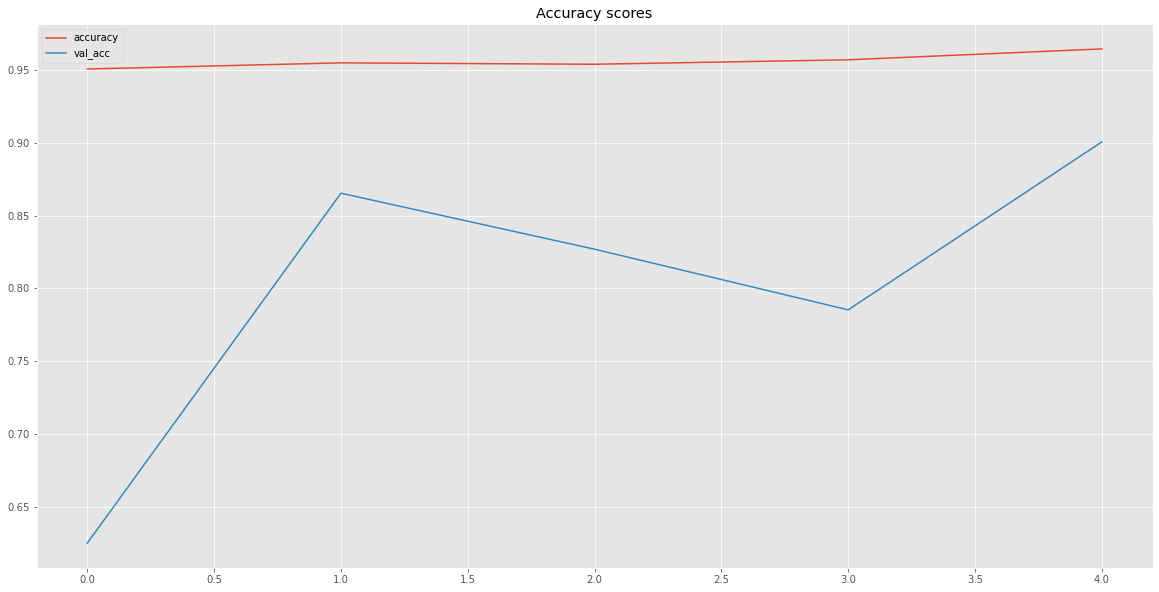

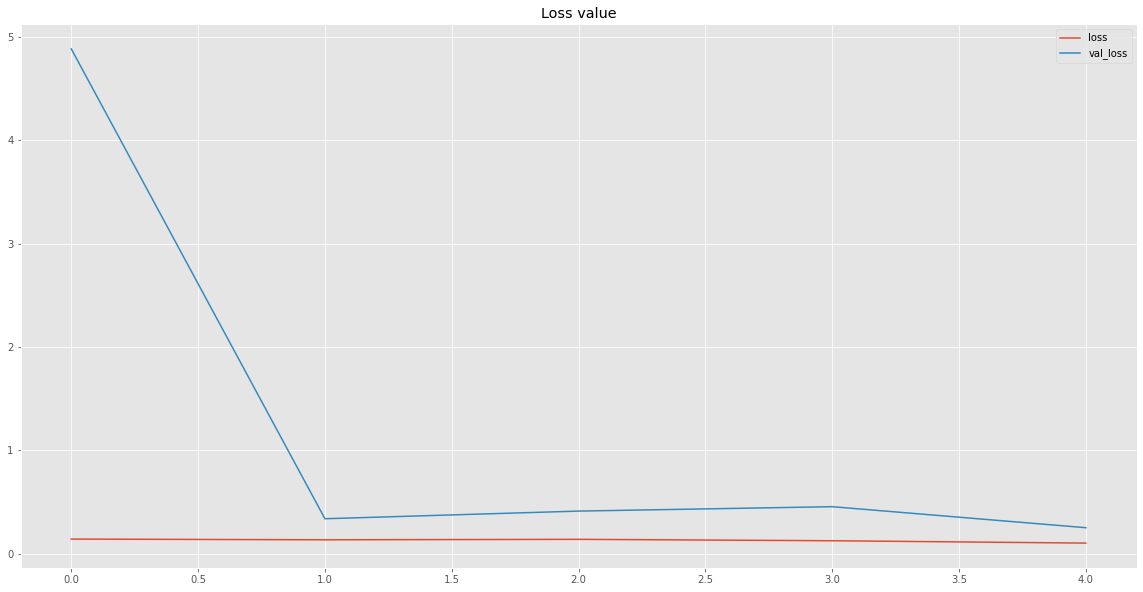

In [40]:
#Setting up image size
plt.figure(figsize=(20,10))

#Plot train and validation accuracy
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_acc'])
plt.show()

#Plot train and validation loss
plt.figure(figsize=(20,10))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

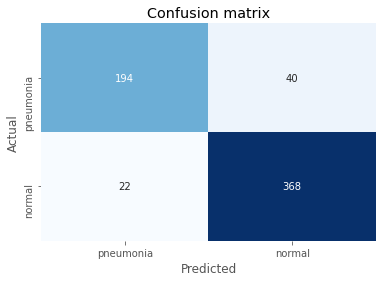

In [41]:
#predicting the model on test data
predictions=model.predict(X_test)

#Inverse transform the encoded images
predictions=encode.inverse_transform(predictions)

#Creating confusion matrix
cm=confusion_matrix(y_test,predictions)

#Plotting confusion matrix
labels=['pneumonia','normal']
plt.title('Confusion matrix')
sns.heatmap(cm,cbar=False,xticklabels=labels,yticklabels=labels,fmt='d',annot=True,cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
#Calculating classification metrics
tn,fp,fn,tp=cm.ravel()
precision=tp/(tp+fp)*100
recall=tp/(tp+fn)*100
F1score=(2*precision*recall/(precision+recall))

#Displaying the metrix results
print("Precision:",precision)
print("Recall:",recall)
print("F1 score:",F1score)

eval_result=model.evaluate_generator(testgen,624)
print("Accuracy:{}%".format(round(eval_result[1]*100,2)))

Precision: 90.19607843137256
Recall: 94.35897435897435
F1 score: 92.23057644110276
Accuracy:85.42%


<h3 style="background-color:blue;font-family:newtimeroman;font-size:200%;text-align:center;border-radius: 15px 50px;">Acknowledgement and References</h3>


* [Pneumonia Prediction: A guide for your first CNN project](https://www.analyticsvidhya.com/blog/2021/05/pneumonia-prediction-a-guide-for-your-first-cnn-project/)
* [Deep Learning for Detecting Pneumonia from X-ray Images](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8)